# Example - Live-Cell Actin Filaments

This notebook is a demonstration of the super-resolution fluorescence imaging method, pysofi, on live-cell imaging data. **(TODO: add sample data details, e.g. what cell. fluorescent protein, magnification, EMCCD camera)**. The raw video was cropped to choose the field-of-view with proper pixel intensities and divided up into 20 blocks with proper dynamics ([ref](https://www.biorxiv.org/content/10.1101/500819v3.supplementary-material?versioned=true)). The dataset is composed of 20 tiff videos in sequence ('Block1.tif' to 'Block20.tif'), and each video has 200 frames. This notebook shows a standard workflow of pysofi to achieve high order Super-resolution Optical Fluctuation Imaging (SOFI) images. Briefly, we demonstrate a pipeline of
1. Fourier interpolation 
2. Moments reconstrtuction or cumulants reconstruction 
3. Noise filtering 1 
4. Shrinking kernel deconvolution
5. Noise filtering 2 
6. Local dynamic range compression (ldrc)

In the end, the processed image / video will be saved into a new tiff file with the colormap the user selects.

Before running the notebook, please make sure you have set up the environment. You can install all required packages with:

<pre><code>pip install -r environment.txt
</code></pre>

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import visualization as v
from functions import (data, filtering, masks, finterp)
import tifffile as tiff
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

## Load Image / Video (Tiff Files)

This sample dataset has 20 tiff files in an order from 1 to 20. First, we generate a list of filenames by their sequence, and load all videos into a dictionary (dset), where keys are filenames in the list (e.g. 'Block1.tif') and values are Data objects (<functions.data.Data at 0x1cab5599760>).

In [2]:
filenum = 20
filepath = '../SampleData'
filenames = ['Block' + str(i+1) + '.tif' for i in range(filenum)]
dset = {}

for filename in filenames:
    dset[filename] = data.Data(filepath, filename)

If you don't get any message, the file is loaded successfully. We can check basic information of each data object including **dimensions** and **frame numbers**. For instance, for the third video ('Block3.tif'), we can get:

In [3]:
print("Information of '" + filenames[2] + "':\n")
    
print('Number of frames: ', dset[filenames[2]].n_frames)
print('Pixel numbers: ', dset[filenames[2]].xdim, '*', dset[filenames[2]].ydim)

Information of 'Block3.tif':

Number of frames:  200
Pixel numbers:  450 * 450


We can also load one frame into an array with function [<code>get_frame(frame_num)<code>](https://github.com/xiyuyi/pysofi/blob/master/functions/data.py).

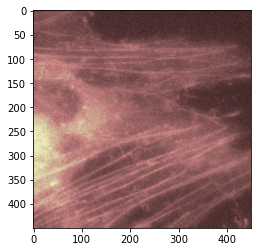

In [4]:
frame_im = dset[filenames[2]].get_frame(2)
plt.imshow(frame_im, cmap='pink')

## 1. Fourier Interpolation

This step performs Fourier interpolation to generate new pixels between physical pixels and reduce pixel sizes of each frame [ref1 - fSOFI, ref2 - fInterpForTiff](https://github.com/xiyuyi/xy_fInterp_forTIFF). The resulting TIFF file can be applied for SOFI processing to produce fSOFI results. 

We can pass a single frame and a list of interpolation factors to [<code>finterp.fourier_interp_array</code>](https://github.com/xiyuyi/pysofi/blob/master/functions/finterp.py), or carry out fourier interpolation on the video (data object) directly with <code>data.finterp_tiffstack</code>. Note that this step might consume large memory or time depending on the tiff file (dimensions, frame number) and the number of new pixels generated. 

We can pass a few parameters to <code>finterp_tiffstack</code>:
+ <code>interp_num_lst</code>: a list of interpolation factors (integers). Interpolation factor represents the number of pixels in the pysical resolution. Based on Nyquist sampling theorem, we recommend to set the interpolation factor to be two times the highest order for moments reconstruction. For instance, if we will generate fourth-order moment-reconstructed image, we set <code>interp_num_lst = [8]</code>, and the new pixel size $d_{new} = \frac{d_{ori}}{8}$.
+ <code>mvlength</code>: the length of the video for interpolation. To save time, for this demo, we choose a small section of our tiff file and set <code>mvlength = 10 </code>.
+ <code>save_option</code>: whether to save the interpolated images into tiff files. Seperate tiff files will be produced for individual interpolation factors in <code>interp_num_lst</code>.
+ <code>return_option</code>: whether to return the interpolated image series as 3d arrays. This is helpful for checking interpolated images and plotting them directly. We recommend to save the interpolated image stack as tiff files instead of returning them if dimensions and number of frames are large.

The user can carry out interpolation first and save the interpolated image / video for following pysofi steps, or skip this step and set <code>finterp = True </code> in moments or cumulants reconstructions. We recommend to set the interpolation factor two times the reconstruction order number based on Nyquist sampling theorem. However, if your computation ability could not support too big interpolation factor, it is practical to use a smaller factor.

In [5]:
# Fourier interpolation on 'Block10'. You can skip this step if you do not need to explore or save interpolated images.
dset[filenames[9]].finterp_tiffstack(interp_num_lst = [2], mvlength = 10, save_option = True, return_option = False)

Calculating interpolation factor = 2...
[==============================] 100.0%



<span style ="color:red">**[COMMENTS]**</span>

<span style="color:blue"> Probably add the comparison here, compare the iamge before/after interpolation </span>

## 2. Moments and cumulants reconstruction

Traditionally, the resolution enhancement of SOFI is manifested by the reduced width of the point spread function (PSF) in the cumulants-reconstructed SOFI image. However, one reason that limits the resolution enhancement of high-order SOFI is the positive and negative oscillations of the cumulants. The boundaries between the negative and positive regions generates “cusp artifacts” in high-order cumulant-reconstructed images ([reference1](https://www.biorxiv.org/content/10.1101/545574v2.full.pdf), [reference2](https://www.osapublishing.org/DirectPDFAccess/A6788588-C50E-4AEF-B956128BA241884C_409047/boe-10-5-2430.pdf?da=1&id=409047&seq=0&mobile=no)). 

A practical (but mathematically nonrigorous) solution to avoiding cusp artifacts is to use moments reconstruction. Even-order moments are always positive and immune to cusp artifacts while keeping the resolution enhancement. Thus, in pysofi, high-order moments reconstruction is used. Since cumulant and moment are interchangable, we can easily get cumulants-reconstructed images after moments reconstruction.

<code>d.moment_image</code> is a method of the Data object that returns the moment-reconstructed images of a defined order. We can pass the order we want to the method (e.g. <code>order = 6</code>) to get high-resolution SOFI images. The moments-reconstructed images are saved as attributes of each Data object in a dictionary <code>d.moments_set</code>, where keys are order numbers and values are reconstruction arrays. We can save all reconstructions in one dictionary <code>m_set</code> as well.

In [6]:
m_set = {}
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    m_set[filename] = dset[filename].moment_image(order=6, finterp = False)
    #tiff.imwrite('moments_set6.tif', np.int64(np.around(m_set[filename])), dtype='int64',append=True)


Calculating Block1.tif...
[=============================] 100.0%
Calculating Block2.tif...
[=============================] 100.0%
Calculating Block3.tif...
[=============================] 100.0%
Calculating Block4.tif...
[=============================] 100.0%
Calculating Block5.tif...
[=============================] 100.0%
Calculating Block6.tif...
[=============================] 100.0%
Calculating Block7.tif...
[=============================] 100.0%
Calculating Block8.tif...
[=============================] 100.0%
Calculating Block9.tif...
[=============================] 100.0%
Calculating Block10.tif...
[=============================] 100.0%
Calculating Block11.tif...
[=============================] 100.0%
Calculating Block12.tif...
[=============================] 100.0%
Calculating Block13.tif...
[=============================] 100.0%
Calculating Block14.tif...
[=============================] 100.0%
Calculating Block15.tif...
[=============================] 100.0%
Calculating Block1

Here, we can choose to conduct Fourier interpolation on each frame before the reconstruction by passing e.g. <code>order = 4, finterp = True, interp_num = 8</code> to the function. Since Fourier interpolation would create almost 8\*8 = 64 times more pixles in this case, this step might some time. If your computation ability could not support too big interpolation factor, it is practical to use a smaller factor.

We recommend to check interpolated images with different factors by calling <code>d.finterp_tiffstack</code> with a list of interpolation numbers like <code>interp_num_lst = [4,5,8]</code>, and pass only one factor for moments-reconstruction and further pysofi steps.

In [7]:
m_set_finterp = {}
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    m_set_finterp[filename] = dset[filename].moment_image(order = 4, finterp = True, interp_num = 1)
    tiff.imwrite('finterp4.tif', np.int64(np.around(m_set_finterp[filename])), dtype='int64',append=True)


Calculating Block1.tif...
[=============================] 100.0%
Calculating Block2.tif...
[=============================] 100.0%
Calculating Block3.tif...
[=============================] 100.0%
Calculating Block4.tif...
[=============================] 100.0%
Calculating Block5.tif...
[=============================] 100.0%
Calculating Block6.tif...
[=============================] 100.0%
Calculating Block7.tif...
[=============================] 100.0%
Calculating Block8.tif...
[=============================] 100.0%
Calculating Block9.tif...
[=============================] 100.0%
Calculating Block10.tif...
[=============================] 100.0%
Calculating Block11.tif...
[=============================] 100.0%
Calculating Block12.tif...
[=============================] 100.0%
Calculating Block13.tif...
[=============================] 100.0%
Calculating Block14.tif...
[=============================] 100.0%
Calculating Block15.tif...
[=============================] 100.0%
Calculating Block1

We can check the moments-reconstructions with an interactive visualization tool [Bokeh](https://docs.bokeh.org/en/latest/index.html). With this tool, it is easy to zoom in/out, check pixels values and change field-of-view. We can pass a few parameters to <code>v.bokeh_visualization</code>:
+ <code>image</code>: image array to plot. If we need to visualize a RGBA image, use <code>bokeh_visualization_rgba</code> instead.
+ <code>palette</code>: colormap. Our default colormap is 'pink' from matplolib, but you can change to any Bokeh [palette](https://docs.bokeh.org/en/latest/docs/reference/palettes.html) for better visualization. 
+ <code>save_option</code>: whether to sace the interactive session as a html file. The default is <code>False</code>.
+ <code>filename</code>: the filename of the html file. The default is <code>'Image'</code>.
+ <code>imshow_same</code>: whether to plot the image in Bokeh with the same axis direction as <code>matplotlib.pyplot.imshow</code>. The default y axis direction in Bokeh is flipped comparing to imshow. The default is <code>True</code>.

We recommend to use <code>matplotlib.pyplot.imshow</code> to show moments-reconstructions since Bokeh may crash Jupyter Notebook sometimes when the image size is too big. Only when we want to have an interactive image with zoom in/ out or hover tools, we would use Bokeh.

In [8]:
# Plot M6 of 'Block6.tif'
v.bokeh_visualization(m_set[filenames[5]], save_option = False, imshow_same = True)

Loading BokehJS ...

As we can see, high-order moments-reconstructions have a large dynamic range of pixel intensities. To overcome this problem, we conduct local dynamic range compression (ldrc) at step 6.

We can change the image to show and the colormap with Bokeh.

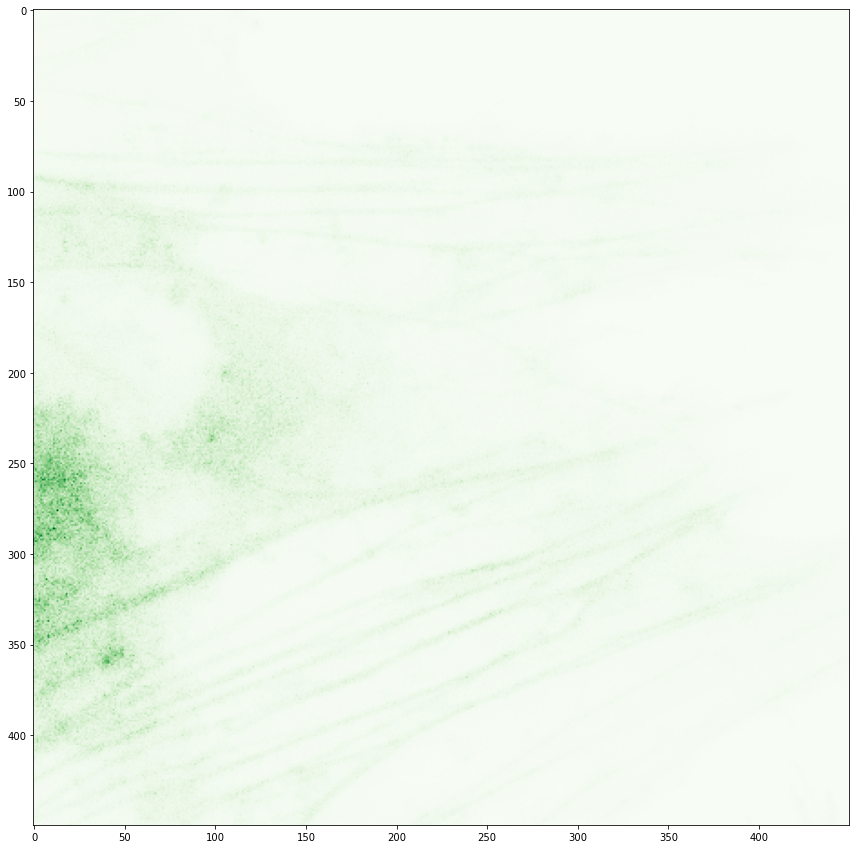

In [9]:
# Plot M4_finterp of 'Block11.tif' with palette 'Greens'
plt.figure(figsize=(15, 15))
plt.imshow(m_set_finterp[filenames[10]], cmap ='Greens')

As you can see from moments-reconstruction step, adding a Fourier interpolation would increase the calculation time by a great amount. This applies to all following steps as well. Thus, based on your purpose and computation ability, please **choose the appropriate interpolation factor**. In each following step, we provide two options for the pysofi demonstration, and you can choose either one accordingly. Please choose **the same option** for all followinf steps.

+ Option 1: pysofi on sixth-order moments-reconstruction series without Fourier interpolation.
+ Option 2: pysofi on Fourier interpolated fourth-order moments-reconstruction series.

## 3. Noise Filtering 1

Moments-reconstruction is performed per block independently, each yield a single frame for further process. Due to the fact that the reconstructed image yielded from each individual block (1 to 20) is severely degraded by noise, we add a step of noise filtering along the time axis for each pixel independently by taking the convolution with a Gaussian kernel. **TODO: how to choose the shape and width of the gaussian kernel.**

We can generate a one-dimensional Gaussian mask with a defined shape and $\sigma$ by calling the function <code>masks.gauss1D_mask</code>, and conduct filtering with <code>filtering.noise_filter1d</code>. The number of frames does not change after the noise filtering, and each frame is saved to the corresponding Data object as an attribute. The parameters for function <code>filtering.noise_filter1d</code> are:
+ <code>dset</code>: a dictionary of Data objects that we define when loading data.
+ <code>im_set</code>: a dictionary of images need to be filtered. In our case, keys are filenames and values are moments-reconstructions after fourier interpolation.
+ <code>noise_filter</code>: filtering kernel. The default is a 1D Gaussian kernel with $shape = (1, 21)$ and $\sigma = 2$.
+ <code>filtername</code>: name of the filtered image that add to the Data object as an attribute.
+ <code>filenames</code>: keys (filenames) in im_set.
+ <code>return_option</code>: besides add filtered images to Data objects, whether to return them in a 3D array.

Of course, we can check images after filtering with <code>v.bokeh_visualization</code> as well.

In [10]:
# Option 1: Noise filtering on M6 seriers
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter1d(dset, m_set, nf, filtername = 'noise filter after moments-reconstruction')
# Show filtered array of block 6
print('\n' + filenames[5] + ' ' + dset[filenames[5]].filter_name)
print(dset[filenames[5]].filtered)    

Calculating ...
[====================] 100%
Block6.tif noise filter after moments-reconstruction
[[1.11784114e+14 1.19919823e+14 1.29000911e+14 ... 1.65410618e+13
  1.08904250e+13 1.44300558e+13]
 [1.28919848e+14 1.36967514e+14 1.99305302e+14 ... 9.93491172e+12
  1.23559694e+13 1.06897639e+13]
 [1.07407045e+14 1.20341017e+14 1.46578743e+14 ... 1.05988398e+13
  9.36906807e+12 2.20868574e+13]
 ...
 [1.16422876e+15 1.52009445e+15 1.43301347e+15 ... 1.93333172e+13
  3.60733848e+13 4.80603123e+13]
 [2.15874452e+15 1.64795289e+15 1.50342455e+15 ... 3.58878041e+13
  2.80650132e+13 3.75926274e+13]
 [1.61666611e+15 1.41041060e+15 1.53754132e+15 ... 1.85139794e+14
  1.99134775e+13 2.48254364e+13]]


In [11]:
# Option 2: Noise filtering on M4_finterp seriers
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter1d(dset, m_set_finterp, nf, filtername = 'noise filter after fourier interpolation and moments-reconstruction')
# Show filtered array of block 2
print('\n' + filenames[1] + ' ' + dset[filenames[1]].filter_name)
print(dset[filenames[1]].filtered)    

Calculating ...
[====================] 100%
Block2.tif noise filter after fourier interpolation and moments-reconstruction
[[7.95924284e+08 7.12318149e+08 1.01639228e+09 ... 2.49410046e+08
  2.24293418e+08 2.38245343e+08]
 [1.11689913e+09 1.07712663e+09 1.08897390e+09 ... 1.73990875e+08
  2.04888247e+08 2.21517019e+08]
 [8.16392862e+08 8.74538621e+08 9.48459775e+08 ... 1.76532921e+08
  2.42119099e+08 3.02341623e+08]
 ...
 [3.43414558e+09 4.29195080e+09 4.70227294e+09 ... 3.33845989e+08
  3.49219888e+08 3.82552414e+08]
 [4.08326612e+09 5.13077596e+09 5.29444230e+09 ... 5.06106123e+08
  3.86858358e+08 4.65411922e+08]
 [5.60064583e+09 6.00303529e+09 6.03533220e+09 ... 5.38087281e+08
  4.18459863e+08 3.52080668e+08]]


## 4. Shrinking Kernel Deconvolution

Deconvolution is then applied on each frame of the noise filtered movie to further enhance the spatial resolution. Since using moments-reconstructions get rid of cusp-artifacts, this step can further enhance the resolution by a factor of $\sqrt{n}$. The idea is that the Gaussian deconvolution kernel can be decomposed into a consecutive convolution of a series
of narrower Gaussian functions. The algorithm decomposes the overall PSF into a series of small PSFs, and deconvolves them one after another, such that for each individual deconvolution step it is a lighter deconvolution task, because the target is more similar to the input image.
**TODO: more detailed introduction of the shrinking kernel deconvolution and meaning of lambda/iteration is provided in [ref](xiyu's thesis). how to determine psf (calibration or calculation from the optical setup), lambda, and iteration number.**

We can generate the original guess of the PSF (<code>d.deconv_psf0 = masks.gauss2D_mask((401, 401), 2)</code>), $\lambda$ (<code>deconv_lambda = 1.5</code>) and iteration number (<code>deconv_iter = 20</code>), and pass them to <code>d.deconvsk</code>. 

In [12]:
# Option 1: Shrinking kernal deconvolution on filtered M6
deconv_psf0 = masks.gauss2D_mask((51, 51), 2)
deconv_psf0 = deconv_psf0 / np.max(deconv_psf0)
deconv_lambda = 1.5
deconv_iter = 20
deconv_set  = {}

for filename in filenames:
    print('\n' + filename)
    im = dset[filename].filtered
    deconv_set[filename] = dset[filename].deconvsk(deconv_psf0, im, deconv_lambda, deconv_iter)
    #tiff.imwrite('deconvM6.tif', deconv_set[filename], append=True)    # save tiff stack


Block1.tif
Calculating [=================== ] 100%
Block2.tif
Calculating [=================== ] 100%
Block3.tif
Calculating [=================== ] 100%
Block4.tif
Calculating [=================== ] 100%
Block5.tif
Calculating [=================== ] 100%
Block6.tif
Calculating [=================== ] 100%
Block7.tif
Calculating [=================== ] 100%
Block8.tif
Calculating [=================== ] 100%
Block9.tif
Calculating [=================== ] 100%
Block10.tif
Calculating [=================== ] 100%
Block11.tif
Calculating [=================== ] 100%
Block12.tif
Calculating [=================== ] 100%
Block13.tif
Calculating [=================== ] 100%
Block14.tif
Calculating [=================== ] 100%
Block15.tif
Calculating [=================== ] 100%
Block16.tif
Calculating [=================== ] 100%
Block17.tif
Calculating [=================== ] 100%
Block18.tif
Calculating [=================== ] 100%
Block19.tif
Calculating [=================== ] 100%
Block20.tif
Calculat

In [13]:
v.bokeh_visualization(deconv_set[filenames[3]])

Loading BokehJS ...

In [14]:
# Shrinking kernal deconvolution on filtered M4_finterp
deconv_psf0 = masks.gauss2D_mask((401, 401), 8)
deconv_psf0 = deconv_psf0 / np.max(deconv_psf0)
deconv_lambda = 1.5
deconv_iter = 20
deconv_set  ={}

for filename in filenames:
    print('\n' + filename)
    im = dset[filename].filtered
    deconv_set[filename] = dset[filename].deconvsk(deconv_psf0, im, deconv_lambda, deconv_iter)
    tiff.imwrite('deconv.tif', deconv_set[filename], append=True)    # save tiff stack


Block1.tif
Calculating [=================== ] 100%
Block2.tif
Calculating [=================== ] 100%
Block3.tif
Calculating [=================== ] 100%
Block4.tif
Calculating [=================== ] 100%
Block5.tif
Calculating [=================== ] 100%
Block6.tif
Calculating [=================== ] 100%
Block7.tif
Calculating [=================== ] 100%
Block8.tif
Calculating [=================== ] 100%
Block9.tif
Calculating [=================== ] 100%
Block10.tif
Calculating [=================== ] 100%
Block11.tif
Calculating [=================== ] 100%
Block12.tif
Calculating [=================== ] 100%
Block13.tif
Calculating [=================== ] 100%
Block14.tif
Calculating [=================== ] 100%
Block15.tif
Calculating [=================== ] 100%
Block16.tif
Calculating [=================== ] 100%
Block17.tif
Calculating [=================== ] 100%
Block18.tif
Calculating [=================== ] 100%
Block19.tif
Calculating [=================== ] 100%
Block20.tif
Calculat

## 5. Noise Filter 2

Based on the same reasoning as before, a second noise filter (the same as noise filter 1) is carried out is applied per pixel along the time axis again to remove any possible irregular deconvolution artifacts. Note that the new filtered image is added to the Data object as an attribute and will replace the previous filtered image.

In [15]:
# Option 1: Noise filtering on deconvoluted M6 image sereis
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter1d(dset, 
                         deconv_set, 
                         nf, 
                         filtername = 'noise filter after deconvolution', 
                         filenames=filenames)

Calculating ...
[====================] 100%

In [16]:
# Noise filtering on deconvoluted image sereis
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter1d(dset, 
                         deconv_set, 
                         nf, 
                         filtername = 'noise filter after deconvolution', 
                         filenames=filenames)
#v.bokeh_visualization(dset[filenames[3]].filtered)     # filtered deconvoluted image of block 4

Calculating ...
[====================] 100%

## 6. Local dynamic range compression (ldrc)

High-order cumulants or moments reconstructions result-in images with a large dynamic range of pixel intensities. This ldrc algorithm compresses the dynamic range of these reconstructions with respect to a reference image (mask) while retaining resolution enhancement.The compression is performed locally in a small window that is scanned across the image. For details of the ldrc method, see [ref, Appendix 4](https://www.biorxiv.org/content/10.1101/500819v3.supplementary-material?versioned=true). We can pass the reference image <code>mask_im = d.average_image()</code>, scanning window size <code>window_size = [25,25]</code>, image that needs compression (input_im = d.filtered) to the function.

In [17]:
# LDRC on the filtered deconvoluted M6 image sereis
window_size = [25,25]
ldrc_set = {}

for filename in filenames:
    print('\n' + filename)
    mask_im = dset[filename].average_image()
    ldrc_set[filename] = dset[filename].ldrc(window_size = window_size, 
                                             mask_im = mask_im, 
                                             input_im = dset[filename].filtered)


Block1.tif
Calculating ...
[====================] 100%
Block2.tif
Calculating ...
[====================] 100%
Block3.tif
Calculating ...
[====================] 100%
Block4.tif
Calculating ...
[====================] 100%
Block5.tif
Calculating ...
[====================] 100%
Block6.tif
Calculating ...
[====================] 100%
Block7.tif
Calculating ...
[====================] 100%
Block8.tif
Calculating ...
[====================] 100%
Block9.tif
Calculating ...
[====================] 100%
Block10.tif
Calculating ...
[====================] 100%
Block11.tif
Calculating ...
[====================] 100%
Block12.tif
Calculating ...
[====================] 100%
Block13.tif
Calculating ...
[====================] 100%
Block14.tif
Calculating ...
[====================] 100%
Block15.tif
Calculating ...
[====================] 100%
Block16.tif
Calculating ...
[====================] 100%
Block17.tif
Calculating ...
[====================] 100%
Block18.tif
Calculating ...
[====================] 100%


In [ ]:
# LDRC on the filtered deconvoluted M4-finterp image sereis
window_size = [200, 200]
ldrc_set = {}

for filename in filenames:
    mask_im = dset[filename].average_image_with_finterp(1)
    ldrc_set[filename] = dset[filename].ldrc(window_size = window_size, 
                                             mask_im = mask_im, 
                                             input_im = dset[filename].filtered)


Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[====================] 100%Calculating ...
[=                   ] 7%

<span style="color:red">**[QUESTION]**</span>
what's calculating above? let's modify the output message briefly to make it a bit more intuitive :-)

## Visualization and Save Reuslts

After pysofi processing, we finally get super-resolution images stored in the dictionary <code>ldrc_set</code>. We can check the final images using Bokeh, save single frame into .png file or save the whole video into a .tif or .avi file. We can also enhance the contrast for better demonstration.

In [ ]:
# Plot final image of block 4
v.bokeh_visualization(ldrc_set[filenames[5]])

In [ ]:
# Plot final image of block 10 with contrast enhancement
v.bokeh_visualization_rgba(v.enhance_contrast(ldrc_set[filenames[5]], display_contrast = 1.4))

In [ ]:
# save the final image stack as a .tif file
import tifffile as tiff
for filename in filenames:
    tiff.imwrite('demo_pysofi.tif', ldrc_set[filename], append=True)
# Note that if you want to open the file with applications like ImageJ, use
# tiff.imwrite('demo_pysofi.tif', np.int16(np.around(ldrc_set[filename])), append=True)

In [ ]:
# save the final image stack as a .avi file with enhance contrast
vid_array = np.array([ldrc_set[filename] for filename in filenames])    
save_avi(vid_array, cmap='pink', filename ='demo_pysofi.avi', display_contrast=1.4)